In [1]:
import env
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

# Data Acquisition and initial prep

#### Acquiring data from zillow SQL db

In [2]:
def get_zillow():
    '''
    This function acquires the requisite zillow data from the Codeup SQL database and caches it locally it for future use in a csv 
    document; once the data is accessed the function then returns it as a dataframe.
    '''

    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        query = '''
        SELECT 
            bedroomcnt, 
            bathroomcnt, 
            fullbathcnt
            calculatedbathnbr,
            calculatedfinishedsquarefeet,
            lotsizesquarefeet,
            regionidcity,
            regionidcounty,
            regionidzip,
            roomcnt,
            yearbuilt, 
            transactiondate, 
            fips,
            taxvaluedollarcnt
        FROM 
            properties_2017 
        JOIN
            propertylandusetype USING (propertylandusetypeid)
        JOIN
            predictions_2017 USING (parcelid)
        Where
            propertylandusedesc = 'Single Family Residential' AND 
            transactiondate LIKE '2017-%%'      
        '''
        url = env.get_db_url('zillow')
        df = pd.read_sql(query, url)
        df.to_csv(filename, index = False)

        return df 

In [3]:
df = get_zillow()
df.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,transactiondate,fips,taxvaluedollarcnt
0,4.0,3.0,3.0,2123.0,7310.0,53571.0,1286.0,96978.0,7.0,1959.0,2017-01-10,6059.0,569452.0
1,3.0,2.0,2.0,1230.0,4142.0,12447.0,3101.0,96046.0,0.0,1926.0,2017-01-10,6037.0,29770.0
2,2.0,1.0,1.0,600.0,7043.0,47568.0,1286.0,97003.0,5.0,1948.0,2017-01-10,6059.0,234307.0
3,4.0,2.0,2.0,1463.0,7519.0,12447.0,3101.0,96342.0,0.0,1957.0,2017-01-10,6037.0,109437.0
4,4.0,2.5,2.0,2184.0,8569.0,34278.0,2061.0,96383.0,8.0,1978.0,2017-01-10,6111.0,713482.0


#### Data prep (initial)

Exploring the initial dataset to see what needs to be done to the data prior to splitting and scaling.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedbathnbr             52304 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   lotsizesquarefeet             52072 non-null  float64
 5   regionidcity                  51404 non-null  float64
 6   regionidcounty                52441 non-null  float64
 7   regionidzip                   52415 non-null  float64
 8   roomcnt                       52441 non-null  float64
 9   yearbuilt                     52325 non-null  float64
 10  transactiondate               52441 non-null  object 
 11  fips                          52441 non-null  float64
 12  taxvaluedollarcnt             52440 non-null  float64
dtypes

It looks like regionidcity has about a thousand nulls which is ~2% of the total dataset. I'm going to drop it and look at regionidzip and regionidcity

In [5]:
df = df.drop(columns= 'regionidcity')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   calculatedbathnbr             52304 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   lotsizesquarefeet             52072 non-null  float64
 5   regionidcounty                52441 non-null  float64
 6   regionidzip                   52415 non-null  float64
 7   roomcnt                       52441 non-null  float64
 8   yearbuilt                     52325 non-null  float64
 9   transactiondate               52441 non-null  object 
 10  fips                          52441 non-null  float64
 11  taxvaluedollarcnt             52440 non-null  float64
dtypes: float64(11), object(1)
memory usage: 4.8+ MB


Before I do antyhing else, I'm going to drop all nulls to see how much of my original data remains.

In [6]:
df.dropna().shape[0] / df.shape[0]

0.9896264373295703

98.86% remains, so rather than dealing with them all individually, I'm going to drop all nulls and just deal with the resulting dataset.

In [7]:
df = df.dropna()

In [8]:
df.regionidcounty.value_counts()

3101.0    33543
1286.0    14012
2061.0     4342
Name: regionidcounty, dtype: int64

In [9]:
df[df.regionidcounty == 3101].fips.value_counts()

6037.0    33543
Name: fips, dtype: int64

Since fips and regionidcounty seems to be directly related. I'm dropping this column.

In [10]:
df = df.drop(columns= 'regionidcounty')

In [11]:
df.regionidzip.value_counts()

97319.0    763
97318.0    664
97329.0    564
97328.0    517
97118.0    496
          ... 
95996.0      2
97092.0      1
96038.0      1
96148.0      1
96467.0      1
Name: regionidzip, Length: 379, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51897 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51897 non-null  float64
 1   bathroomcnt                   51897 non-null  float64
 2   calculatedbathnbr             51897 non-null  float64
 3   calculatedfinishedsquarefeet  51897 non-null  float64
 4   lotsizesquarefeet             51897 non-null  float64
 5   regionidzip                   51897 non-null  float64
 6   roomcnt                       51897 non-null  float64
 7   yearbuilt                     51897 non-null  float64
 8   transactiondate               51897 non-null  object 
 9   fips                          51897 non-null  float64
 10  taxvaluedollarcnt             51897 non-null  float64
dtypes: float64(10), object(1)
memory usage: 4.8+ MB


In [13]:
df.transactiondate.min(), df.transactiondate.max()

('2017-01-01', '2017-09-25')

After confirming all these values have transaction dates in 2017, I'm dropping the transactiondate column

In [14]:
df.drop(columns='transactiondate', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51897 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51897 non-null  float64
 1   bathroomcnt                   51897 non-null  float64
 2   calculatedbathnbr             51897 non-null  float64
 3   calculatedfinishedsquarefeet  51897 non-null  float64
 4   lotsizesquarefeet             51897 non-null  float64
 5   regionidzip                   51897 non-null  float64
 6   roomcnt                       51897 non-null  float64
 7   yearbuilt                     51897 non-null  float64
 8   fips                          51897 non-null  float64
 9   taxvaluedollarcnt             51897 non-null  float64
dtypes: float64(10)
memory usage: 4.4 MB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,51897.0,3.306665,0.931528,0.0,3.0,3.0,4.0,11.0
bathroomcnt,51897.0,2.298919,1.009544,1.0,2.0,2.0,3.0,13.0
calculatedbathnbr,51897.0,2.233520,0.984121,1.0,2.0,2.0,3.0,13.0
calculatedfinishedsquarefeet,51897.0,1918.379791,994.041191,152.0,1268.0,1657.0,2300.0,21929.0
lotsizesquarefeet,51897.0,11231.395148,86673.820145,236.0,5581.0,6836.0,8773.0,6971010.0
regionidzip,51897.0,96630.869260,4432.522049,95982.0,96206.0,96412.0,96995.0,399675.0
roomcnt,51897.0,1.902441,3.151508,0.0,0.0,0.0,5.0,15.0
yearbuilt,51897.0,1963.251999,22.970057,1878.0,1950.0,1960.0,1979.0,2016.0
fips,51897.0,6049.131183,21.016057,6037.0,6037.0,6037.0,6059.0,6111.0
taxvaluedollarcnt,51897.0,525504.711159,716440.843481,1000.0,193700.0,372800.0,616238.0,25381250.0


In [16]:
df.bedroomcnt.value_counts()

3.0     23251
4.0     15104
2.0      8260
5.0      3914
6.0       626
1.0       575
7.0       103
0.0        29
8.0        24
9.0         8
10.0        2
11.0        1
Name: bedroomcnt, dtype: int64

29 entries have 0 bedrooms listed, after speaking with someone with domain knowledge, I've determined this has to be junk data so I am throwing this these 29 listings out.

In [17]:
df = df[df.bedroomcnt != 0]

In [18]:
df.roomcnt.value_counts()

0.0     37381
6.0      3970
7.0      3599
8.0      2805
5.0      1871
9.0      1169
4.0       502
10.0      339
11.0      105
3.0        69
12.0       33
13.0        9
2.0         9
14.0        5
1.0         1
15.0        1
Name: roomcnt, dtype: int64

After reviewing the roomcnt column, it seems like this data is just not reliable; so I will be dropping this column.

In [19]:
df.drop(columns = 'roomcnt', inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,51868.0,3.308514,0.928500,1.0,3.0,3.0,4.00,11.0
bathroomcnt,51868.0,2.299231,1.009489,1.0,2.0,2.0,3.00,13.0
calculatedbathnbr,51868.0,2.233805,0.984070,1.0,2.0,2.0,3.00,13.0
calculatedfinishedsquarefeet,51868.0,1918.589361,993.910252,152.0,1268.0,1657.0,2300.25,21929.0
lotsizesquarefeet,51868.0,11228.359123,86697.535793,236.0,5581.0,6834.5,8770.25,6971010.0
regionidzip,51868.0,96631.076386,4433.742906,95982.0,96206.0,96414.0,96995.00,399675.0
yearbuilt,51868.0,1963.265867,22.959844,1878.0,1950.0,1960.0,1979.00,2016.0
fips,51868.0,6049.129984,21.011578,6037.0,6037.0,6037.0,6059.00,6111.0
taxvaluedollarcnt,51868.0,525474.826907,716318.559671,1000.0,193701.5,372917.5,616253.75,25381250.0


### Initial Data Prep Takeaways

- Dropping regionidcity, regionidcounty, transactiondate, and roomcnt columns as I determined they are not needed now.
- Dropping all nulls for ease of dealing with the data. This isn't not much data loss.
- Dropping all rows where bedrroomcnt is equal to 0 as this is inaccurate data.

#### Visualizing the remaining data

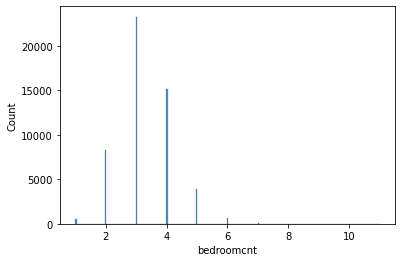

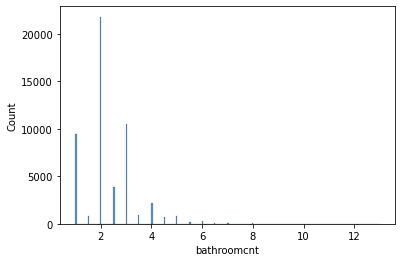

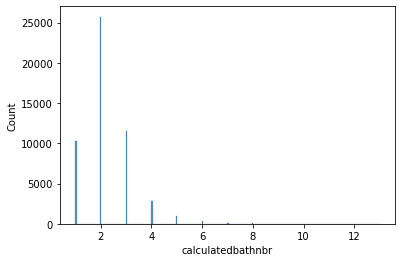

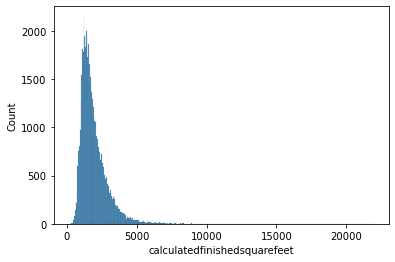

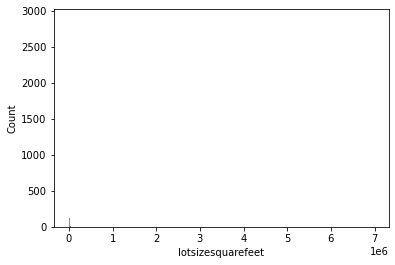

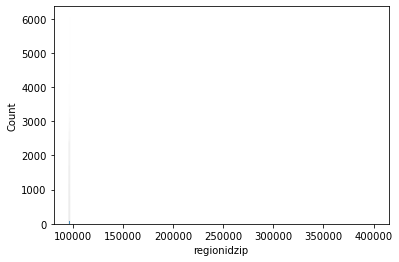

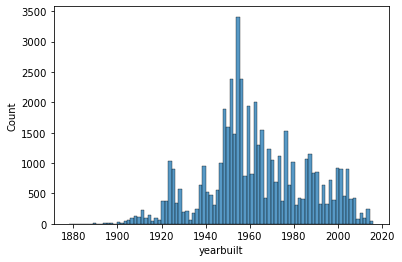

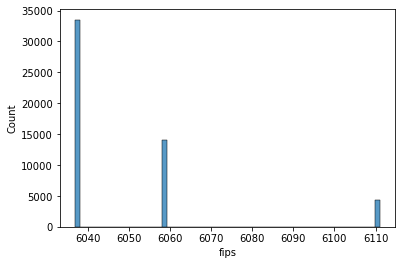

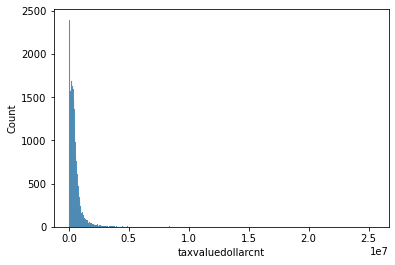

In [20]:
for column in df.columns.tolist():
    sns.histplot(data = df, x = column)
    plt.show()

<AxesSubplot:xlabel='lotsizesquarefeet', ylabel='Count'>

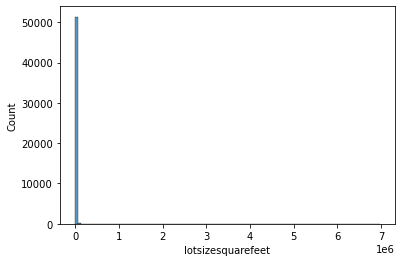

In [21]:
# There are some major outliers apparently in lotsizesquarefeet, so I want to visualize this better

sns.histplot(data = df, x ='lotsizesquarefeet', bins=100)

In [22]:
df.lotsizesquarefeet.sort_values(ascending=False).head(20)

1496     6971010.0
11444    6971010.0
9788     6971010.0
47049    6971010.0
37514    6971010.0
20605    6971010.0
18562    6971010.0
41688    2831752.0
45635    2562259.0
42974    1774617.0
9496     1746019.0
19692    1323788.0
26374    1111919.0
8085      941333.0
8086      941333.0
19741     889495.0
19338     872645.0
19604     872158.0
15560     862329.0
34810     766570.0
Name: lotsizesquarefeet, dtype: float64

Seeing the above numbers it looks like some of these values are outliers. I am going to make the determination to set an upper limit of 300,000 for lotsizesquarefeet which is about 6.9 acres.

In [23]:
df = df[df.lotsizesquarefeet < 300000]

In [24]:
df.shape

(51790, 9)

Now looking at taxvaluedollarcnt outliers

In [25]:
df.taxvaluedollarcnt.sort_values(ascending=False).head(50)

11424    25381250.0
6371     24345695.0
23697    23858374.0
32208    22589311.0
51314    20203475.0
7904     19280700.0
28653    18812604.0
3119     16814671.0
9475     16497812.0
51087    15736374.0
23259    15623925.0
41050    15618488.0
43576    15533020.0
22293    13852918.0
50689    13600098.0
11767    13198250.0
18053    13191321.0
29982    13128583.0
50569    12479401.0
2205     12427324.0
17069    12386870.0
11814    12081475.0
30638    11317682.0
36959    11020600.0
43263    11000000.0
40739    10873908.0
4716     10610405.0
51327    10355345.0
42921    10152678.0
23394    10130485.0
27521    10071018.0
51040    10050974.0
44912     9935000.0
34607     9870514.0
12914     9837579.0
42738     9837578.0
49399     9523337.0
14898     9467005.0
23511     9323011.0
5252      9283780.0
45782     9177942.0
23089     9120827.0
35105     8946027.0
49668     8868009.0
28699     8823765.0
6677      8765700.0
2263      8529934.0
21086     8400047.0
49678     8397673.0
31030     8387524.0


Deciding to set the upper limit on taxvaluedollarcnt at 4 million as that will take care a large number of outliers.

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='Count'>

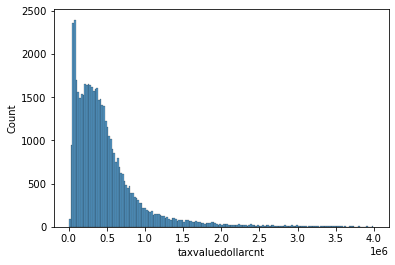

In [26]:
sns.histplot(data = df[df.taxvaluedollarcnt < 4000000], x = 'taxvaluedollarcnt')

In [27]:
df = df[df.taxvaluedollarcnt < 4000000]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51496 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51496 non-null  float64
 1   bathroomcnt                   51496 non-null  float64
 2   calculatedbathnbr             51496 non-null  float64
 3   calculatedfinishedsquarefeet  51496 non-null  float64
 4   lotsizesquarefeet             51496 non-null  float64
 5   regionidzip                   51496 non-null  float64
 6   yearbuilt                     51496 non-null  float64
 7   fips                          51496 non-null  float64
 8   taxvaluedollarcnt             51496 non-null  float64
dtypes: float64(9)
memory usage: 3.9 MB


Now investigating the calculatedfinishedsquarefeet.

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='Count'>

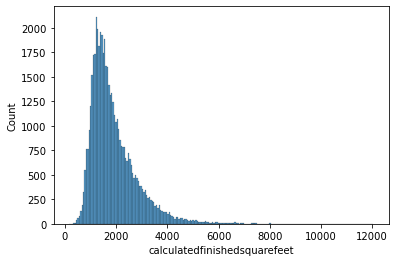

In [29]:
sns.histplot(data = df, x = 'calculatedfinishedsquarefeet')

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='Count'>

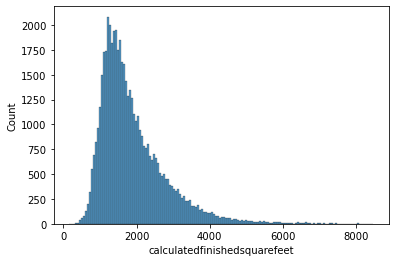

In [30]:
sns.histplot(data = df[df.calculatedfinishedsquarefeet < 8500], x = 'calculatedfinishedsquarefeet')

In [31]:
df[df.calculatedfinishedsquarefeet < 8500].shape

(51475, 9)

In [32]:
df = df[df.calculatedfinishedsquarefeet < 8500]

Deciding to set the upper limit on calculatedfinishedsquarefeet at 8500 as that will take care a large number of outliers and make the model more applicable to the majority of homes.

Making a function which gets rid of nonsense home sizes.`

In [33]:
def minimum_sqr_ft(df):
    '''
    Function that takes in a dataframe and finds the minimum sq footage necessary given an input number of bathrooms and bedrooms.
    
    Returns a total minimum amount
    '''
    # min square footage for type of room
    bathroom_min = 10
    bedroom_min = 70
    
    # total MIN sqr feet
    total = (df.bathroomcnt * bathroom_min) + (df.bedroomcnt * bedroom_min)
    # return MIN sqr feet
    return total

def clean_sqr_feet(df):
    '''
    Takes in a dataframe, finds the theoretical minimum sq footage given bathroom and bedroom inputs and compares that to the actual
    given sq footage.  
    Returns a dataframe where containing results only having an actual sq footage larger than the calculate minimum.
    '''
    # get MIN sqr ft
    min_sqr_ft = minimum_sqr_ft(df)
    # return df with sqr_ft >= min_sqr_ft
    # change 'sqr_ft' to whichever name you have for sqr_ft in df
    return df[df.calculatedfinishedsquarefeet >= min_sqr_ft]



In [34]:
df = clean_sqr_feet(df)

In [35]:
df.shape

(51474, 9)

Creating a function that maps actual county names to the dataset instead of having fip numbers.

In [36]:
def map_counties(df):
    # identified counties for fips codes 
    counties = {6037: 'los_angeles',
                6059: 'orange',
                6111: 'ventura'}
    # map counties to fips codes
    df.fips = df.fips.map(counties)
    df.rename(columns=({ 'fips': 'county'}), inplace=True)
    return df

In [37]:
df = map_counties(df)

In [38]:
df.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
0,4.0,3.0,3.0,2123.0,7310.0,96978.0,1959.0,orange,569452.0
1,3.0,2.0,2.0,1230.0,4142.0,96046.0,1926.0,los_angeles,29770.0
2,2.0,1.0,1.0,600.0,7043.0,97003.0,1948.0,orange,234307.0
3,4.0,2.0,2.0,1463.0,7519.0,96342.0,1957.0,los_angeles,109437.0
4,4.0,2.5,2.0,2184.0,8569.0,96383.0,1978.0,ventura,713482.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51474 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51474 non-null  float64
 1   bathroomcnt                   51474 non-null  float64
 2   calculatedbathnbr             51474 non-null  float64
 3   calculatedfinishedsquarefeet  51474 non-null  float64
 4   lotsizesquarefeet             51474 non-null  float64
 5   regionidzip                   51474 non-null  float64
 6   yearbuilt                     51474 non-null  float64
 7   county                        51474 non-null  object 
 8   taxvaluedollarcnt             51474 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.9+ MB


In [40]:
df.bedroomcnt = df.bedroomcnt.astype('uint8')
df.bathroomcnt = df.bathroomcnt.astype('float16')
df.calculatedbathnbr = df.calculatedbathnbr.astype('float16')
df.yearbuilt = df.yearbuilt.astype('uint16')
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.astype('uint16')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51474 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    51474 non-null  uint8  
 1   bathroomcnt                   51474 non-null  float16
 2   calculatedbathnbr             51474 non-null  float16
 3   calculatedfinishedsquarefeet  51474 non-null  uint16 
 4   lotsizesquarefeet             51474 non-null  float64
 5   regionidzip                   51474 non-null  float64
 6   yearbuilt                     51474 non-null  uint16 
 7   county                        51474 non-null  object 
 8   taxvaluedollarcnt             51474 non-null  float64
dtypes: float16(2), float64(3), object(1), uint16(2), uint8(1)
memory usage: 2.4+ MB


### Simple data viz Takeaways

- There are a lot of outlies skewing the data. I need to remove some of the most egregious outliers:
    - I will remove all entries with a lotsizesquarefeet above 300,000.
    - I will remove all entries with a taxvaluedollarcnt above 4,000,000.
    - I will remove all entries with a calculatedfinishedsquarefeet above 8500.
    - These will take care of the majority of skewness we saw in the above plots
- I also need to deal with houses whose doesn't make sense for the number of rooms I see listed. I wrote a function that will discard all enties where a theoretical mimimum calculated on bathroom and bedroom number is not met.
- I want to change the fips column to be more useful to read as it's categorical data. I am mapping the county names to the numbers given and renaming the column to 'county'.
- Finally I change some datatypes to make the data more memory efficient.

Final dataset is 51474 entries which is 98.2% of the original 52441 entries which existed before cleaning. Even after cleaning and cutting we retain almost all the data. This means the usable model will be more able to predict on the vast majority of single family residential homes.

# Data Preparation

In [42]:
# scaler
from sklearn.preprocessing import MinMaxScaler
# train test split from sklearn
from sklearn.model_selection import train_test_split

Creating functions to prepare the dataset for EDA.

In [43]:
def split_zillow(df):
    '''
    Takes in a cleaned zillow dataframe, splits it into train, validate and test subgroups and then returns those subgroups.
    
    Arguments: df - a cleaned pandas dataframe with the expected feature names and columns in the zillow dataset
    Return: train, validate, test - dataframes ready for the exploration and model phases.
    '''
    train, test = train_test_split(df, train_size = 0.8, random_state = 1234)
    train, validate = train_test_split(train, train_size = 0.7, random_state = 1234)
    return train, validate, test

def data_scaler(train, validate, test, columns_to_scale):
    '''
    This function takes in train, validate, test subsets of the cleaned zillow dataset and using the train subset creates a min_max 
    scaler. It thens scales the subsets and returns the train, validate, test subsets as scaled versions of the initial data.

    Arguments:  train, validate, test - split subsets from of the cleaned zillow dataframe
                columns_to_scale - a list of column names to scale
    Return: scaled_train, scaled_validate, scaled_test - dataframe with scaled versions of the initial unscaled dataframes 
    '''
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.fit_transform(train[columns_to_scale]), 
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])

    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])

    return train_scaled, validate_scaled, test_scaled

In [44]:
train, validate, test = split_zillow(df)

In [45]:
train.shape, validate.shape, test.shape

((28825, 9), (12354, 9), (10295, 9))

In [46]:
train.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,2,2.0,2.0,1538,8370.0,96424.0,1938,los_angeles,102269.0
2568,4,2.0,2.0,1176,6096.0,96464.0,1954,los_angeles,324566.0
21142,4,3.5,3.0,2288,2920.0,97035.0,2004,orange,709000.0
697,3,2.0,2.0,1603,5859.0,96111.0,1947,los_angeles,351733.0
24151,3,2.5,2.0,2463,7306.0,97084.0,2004,ventura,610000.0


Train subset ready for EDA. This is the same data as below in the train_scaled subset but not scaled as to make EDA easier to do.

In [47]:
train_scaled, validate_scaled, test_scaled = data_scaler(train, validate, test, columns_to_scale=(df.drop(columns = ['county', 'taxvaluedollarcnt']).columns))

In [48]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((28825, 9), (12354, 9), (10295, 9))

In [49]:
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,0.125,0.1250,0.125,0.151623,0.027058,0.001455,0.434783,los_angeles,102269.0
2568,0.375,0.1250,0.125,0.107287,0.019260,0.001587,0.550725,los_angeles,324566.0
21142,0.375,0.3125,0.250,0.243478,0.008368,0.003467,0.913043,orange,709000.0
697,0.250,0.1250,0.125,0.159584,0.018447,0.000425,0.500000,los_angeles,351733.0
24151,0.250,0.1875,0.125,0.264911,0.023409,0.003629,0.913043,ventura,610000.0


Subsets train_scaled, validate_scaled, test_scaled ready for modeling after EDA is complete.

# Explore (Exploratory Data Analysis)

My thoughts from before the data analysis.
- I'm pretty most of the features will be postively correlated in some way with the target. Though not all my be strong.
- I think lotsizesquarefeet and calculatedfinishedsquarefeet will have the strongest relationship with the target.
- I'm unsure how strongly bathroomcnt will correlate, but I suspet bedroomcnt will be relatively strong.
- I don't think regionidzip will have any significant relationship with the target as these are actually categorical data in numerical form.

In [50]:
# Writing a function that plots pairs of continuous variables to visualize all the potential relationships.
from itertools import combinations

def plot_variable_pairs(df, to_drop = None):
    '''
    This function takes in a dataframe and plots all possible numerical data pairs in scatterplots with a regression 
    line. The function only plots unique combinations of pairs, not permutations, e.g. only prints column a by 
    column b, but leaves out column b by column a. This reduces clutter and runtime.
    
    arguments: df - A dataframe with numerical columns
               to_drop - a list of columns to drop or not include in the plots
    returns: This function returns nothing; it merely plots out the scatterplots
    '''
    
    if to_drop == None:
        columns_to_plot = df.select_dtypes(include = 'number').columns
        plot_tuples = []
        for i in combinations(columns_to_plot,2):
            plot_tuples.append(i)

        for i in plot_tuples:
            sns.lmplot(x = i[0], y = i[1], data = df, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)
            plt.plot()
            plt.show()
    else:
        columns_to_plot = df.select_dtypes(include = 'number').columns.drop(to_drop)
        plot_tuples = []
        for i in combinations(columns_to_plot,2):
            plot_tuples.append(i)

        for i in plot_tuples:
            sns.lmplot(x = i[0], y = i[1], data = df, line_kws={'color': '#FF5E13', 'linewidth': 3},  height=5, aspect=1.5)
            plt.plot()
            plt.show()

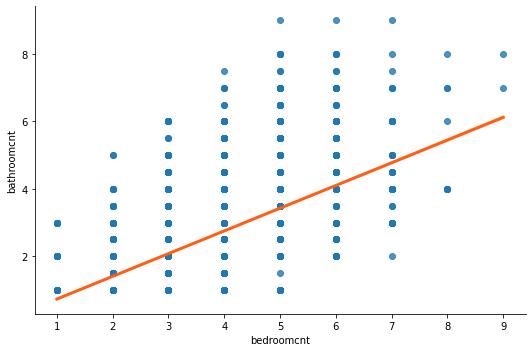

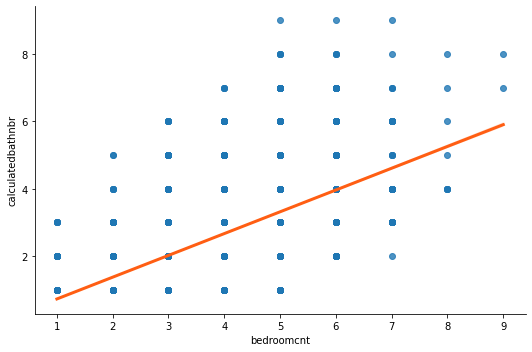

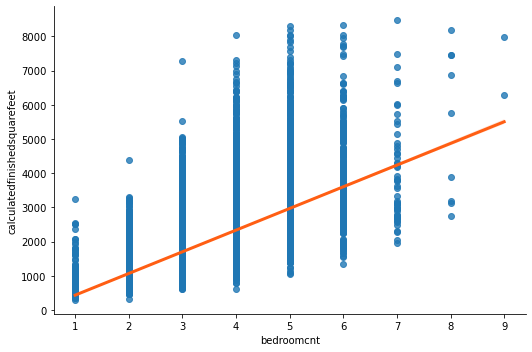

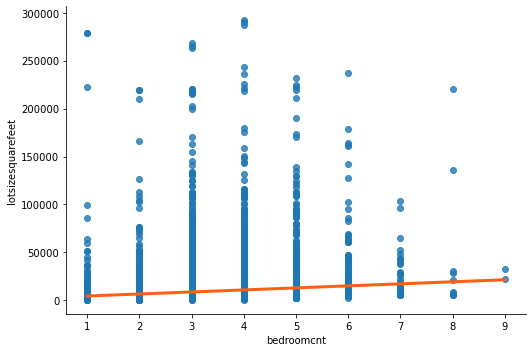

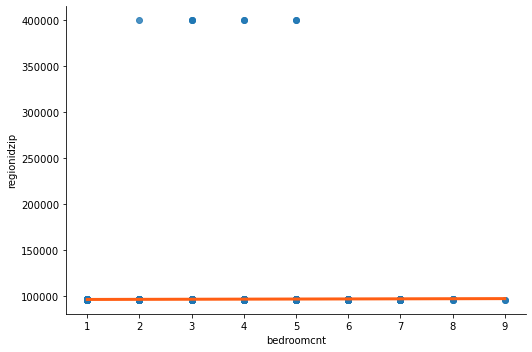

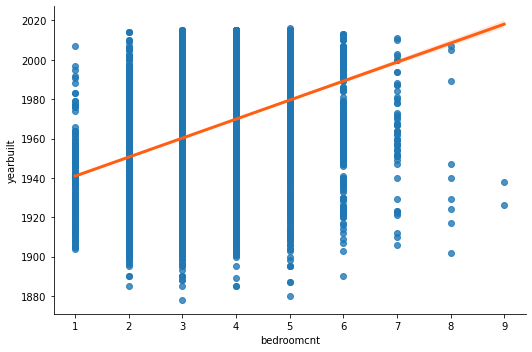

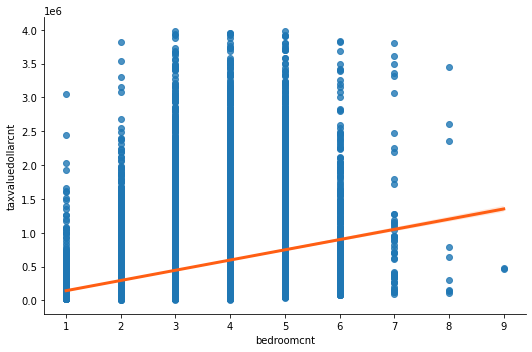

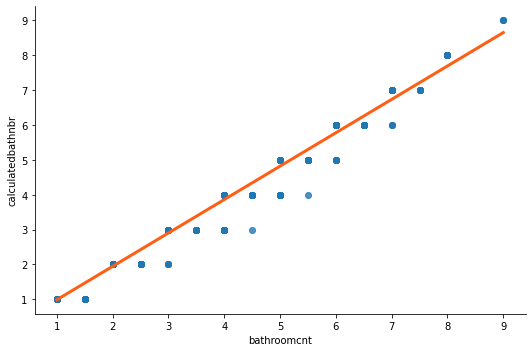

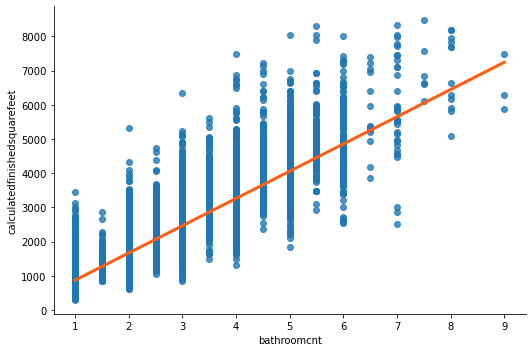

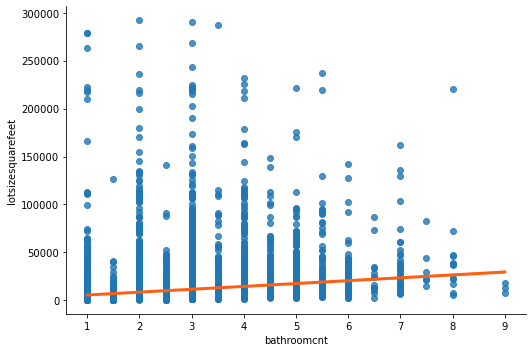

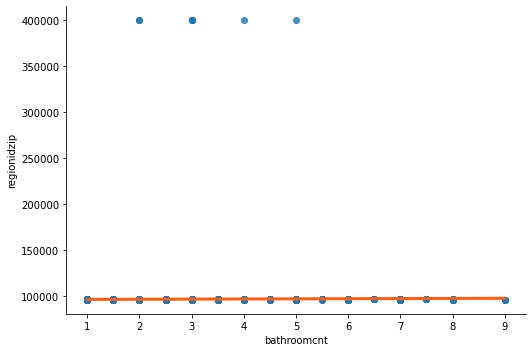

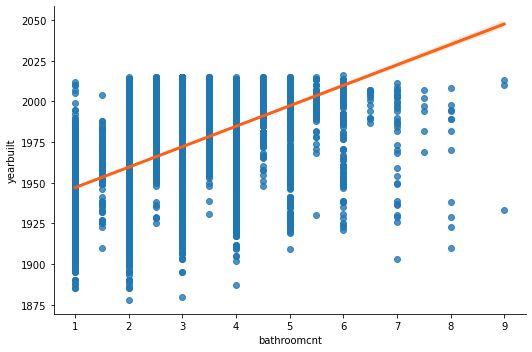

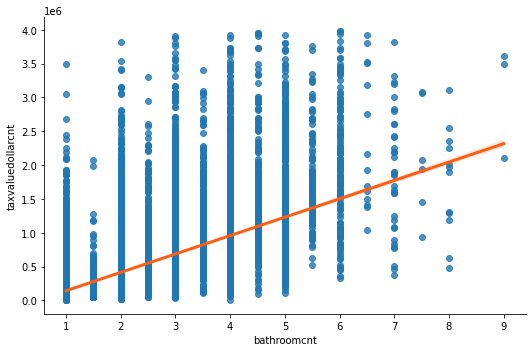

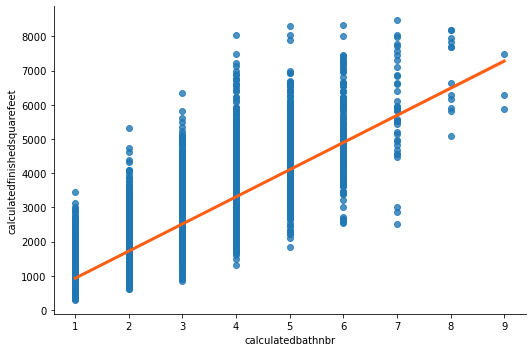

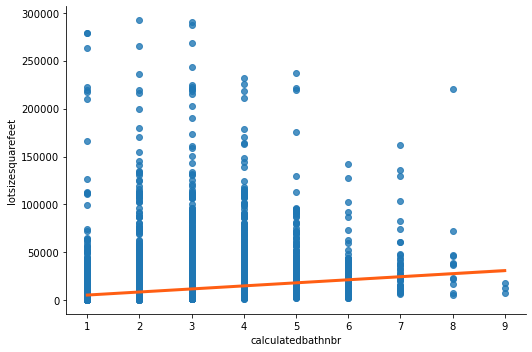

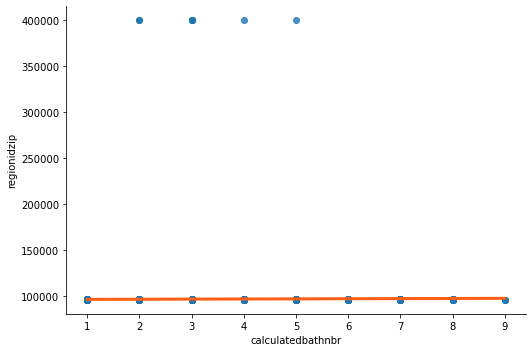

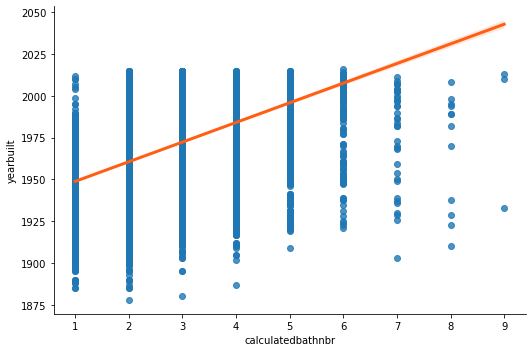

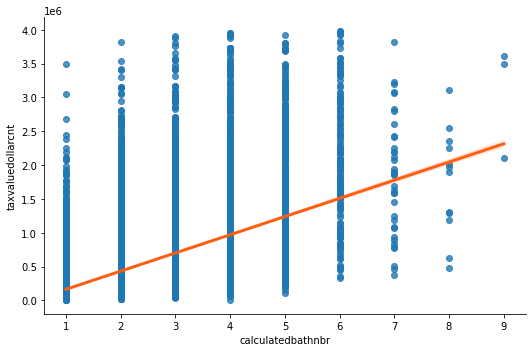

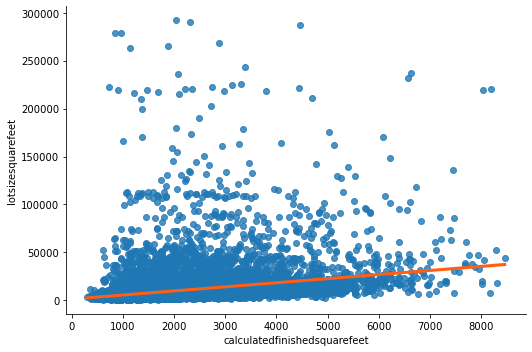

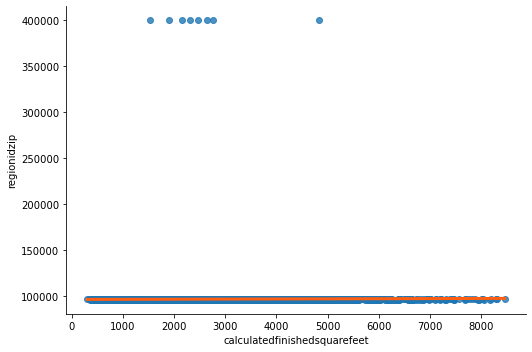

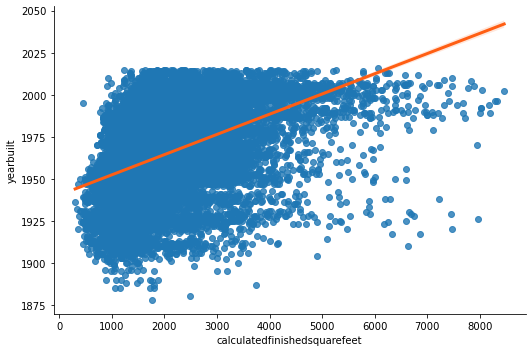

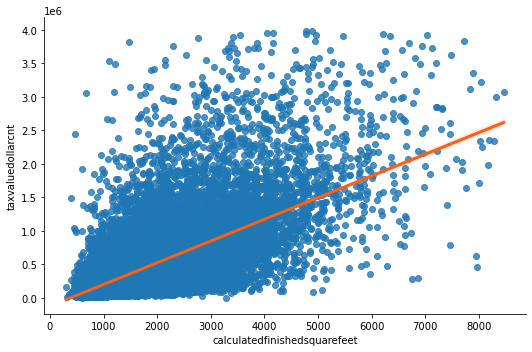

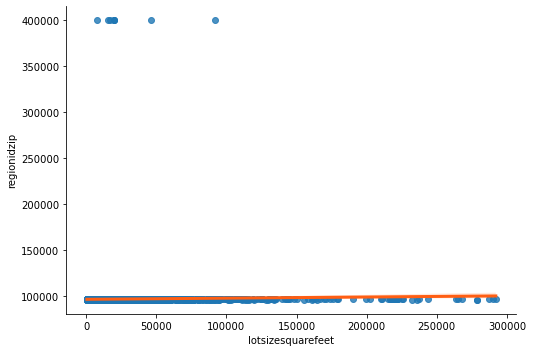

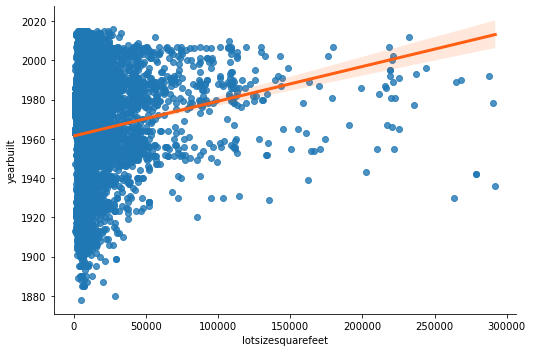

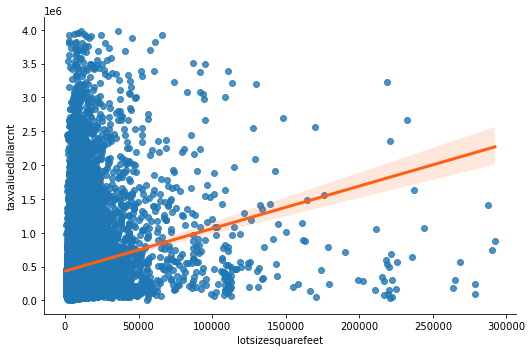

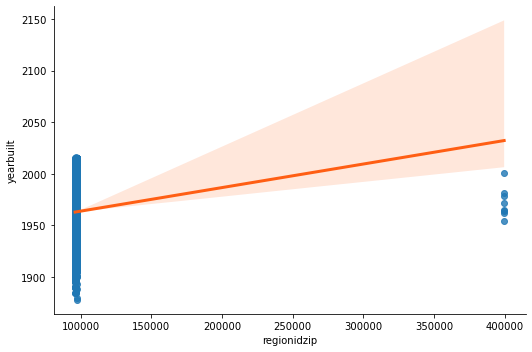

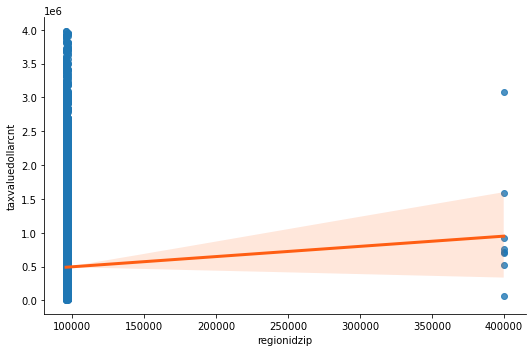

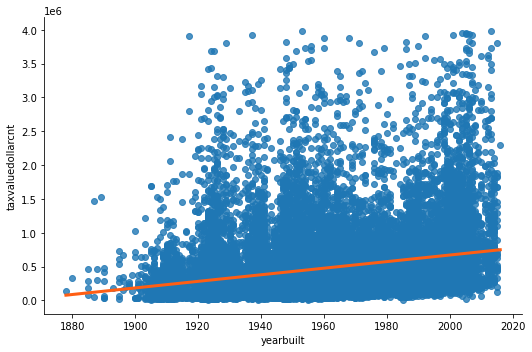

In [51]:
plot_variable_pairs(train)

### Takeaways from continuous variable plotting

- Clearly some of these are not actually continuous numerical data, they are categorical data: things like bedroomcnt and bathroomcnt.
- It appears like there is a correlation with the target feature for every continuous variable, though it remains to be seen how strong it is.
- Just from visually inspection, it looks as though calculatedfinishedsquarefeet is the tightest correlation to the target variable.

In [52]:
# # Writing a function that plots continuous variables with categoricals separated out to visualize all the potential relationships.

def plot_categorical_and_continuous_vars(df, continuous, categorical):
    '''
    This function takes in a dataframe, a list of continuous variables, and a list of categorical variables and does 
    3 plots for each unique combination of categorical and continuous variable.
    
    Arguments: df - a dataframe consisting of continuous and categorical columns
    '''
    plot_list = []
    for cat in categorical:
        for cont in continuous:
            plot_list.append([cat, cont])
    
    for i in plot_list:
        plt.figure(figsize=(18, 5))
        plt.subplot(131)
        sns.boxplot(x=i[0], y=i[1], data=df)
        plt.subplot(132)
        sns.stripplot(x=i[0], y=i[1], data=df)
        plt.subplot(133)
        sns.violinplot(x=i[0], y=i[1], data=df)
#         sns.barplot(x=i[0], y=i[1], data=df)
        plt.show()

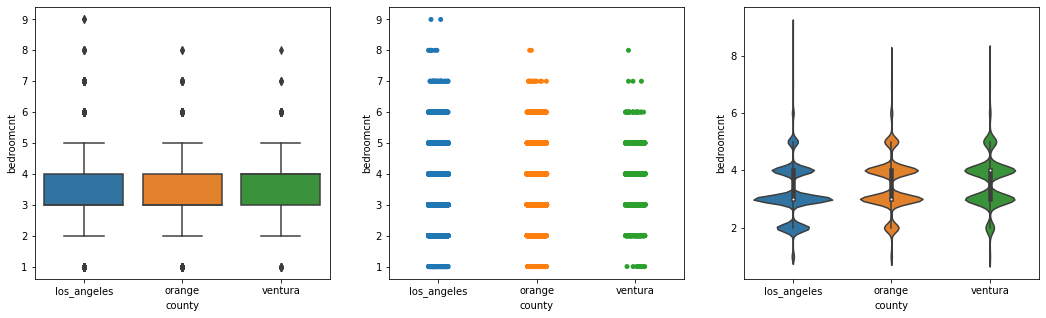

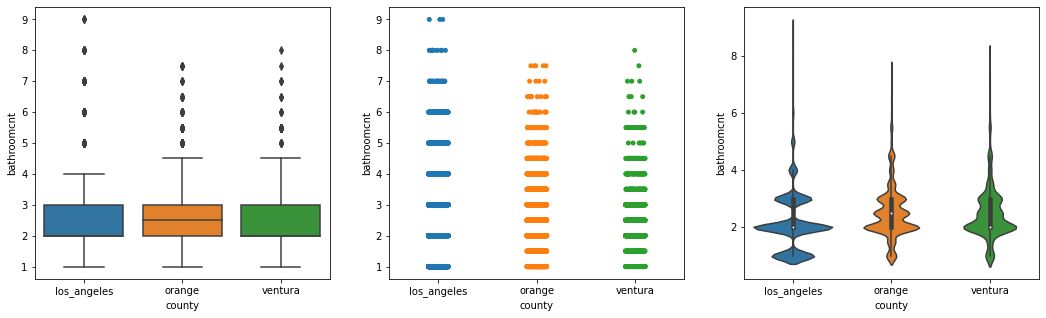

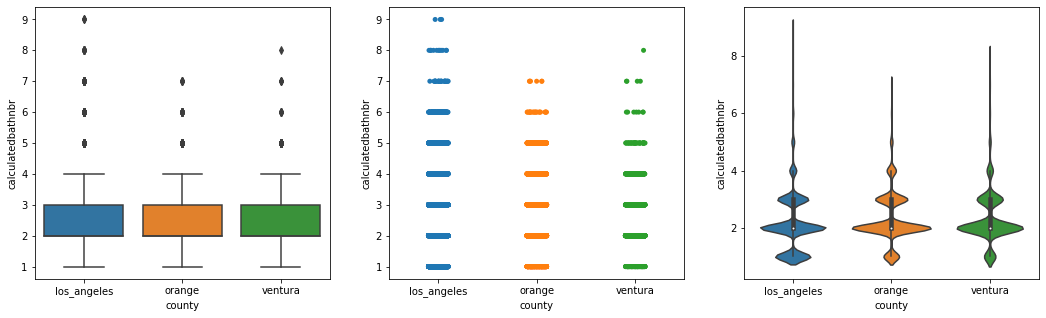

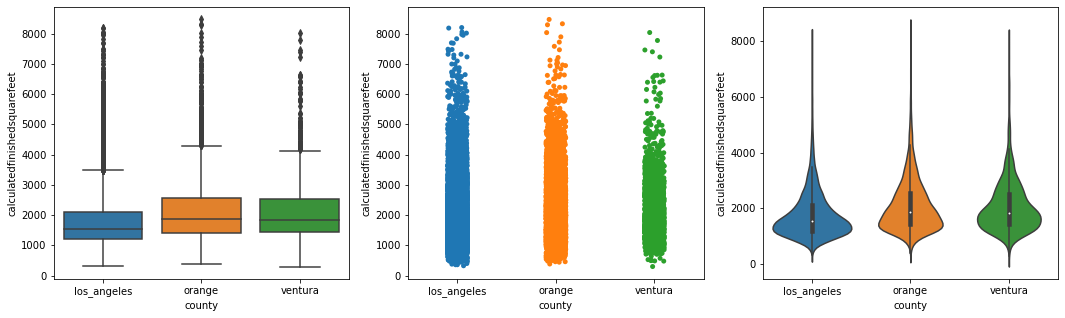

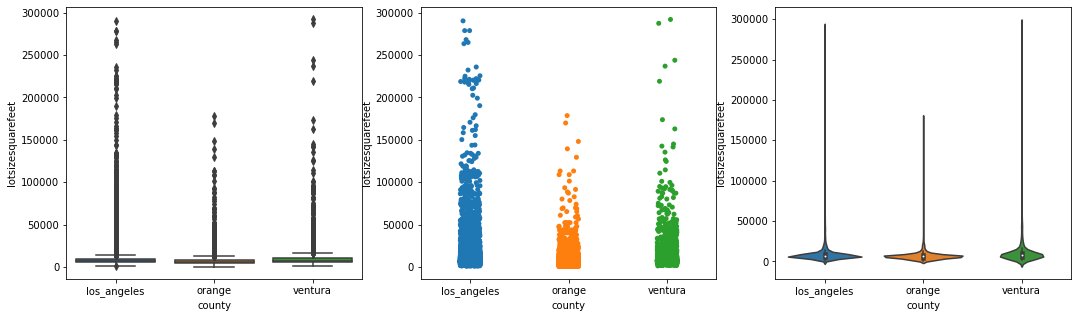

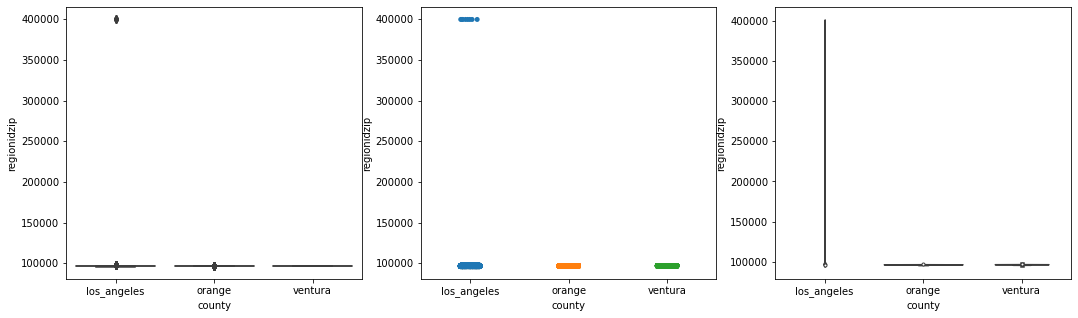

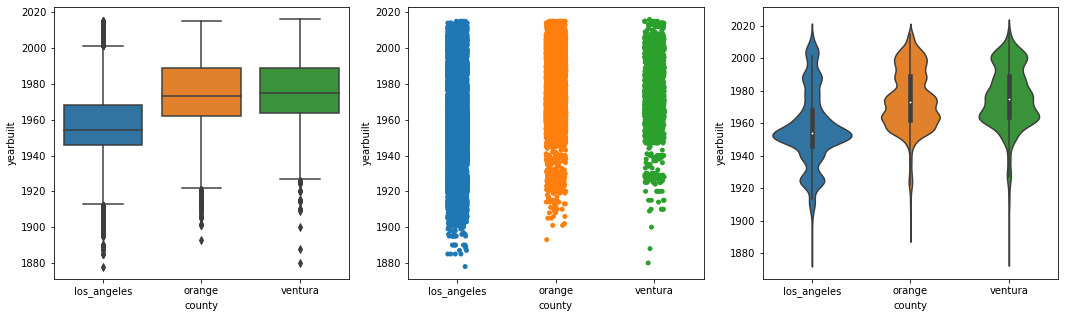

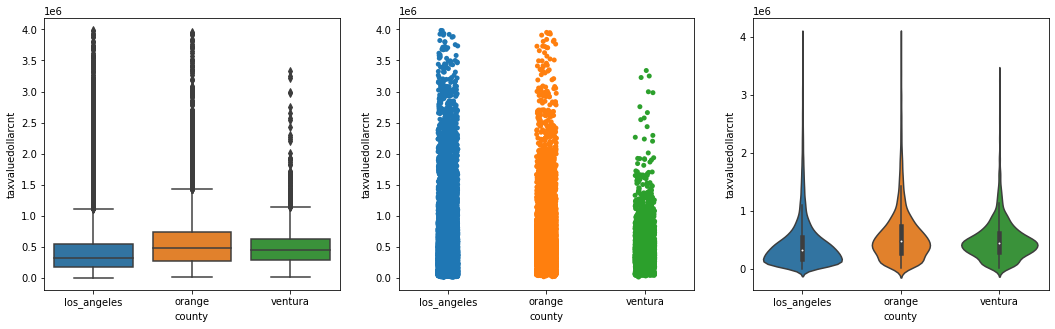

In [53]:
plot_categorical_and_continuous_vars(train, train.select_dtypes('number').columns, train.select_dtypes('object').columns)

Visualizing Individual data separated by county by iterating through all features on x and target on y

In [54]:
columns_to_viz = train.select_dtypes('number').drop(columns='taxvaluedollarcnt').columns.tolist()

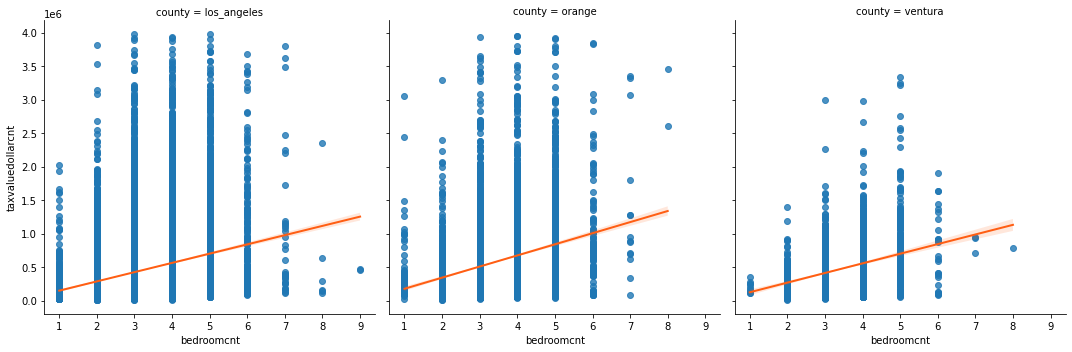

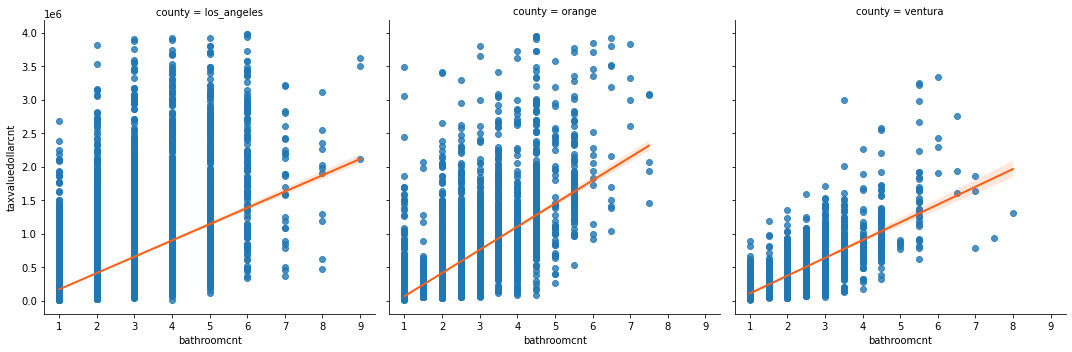

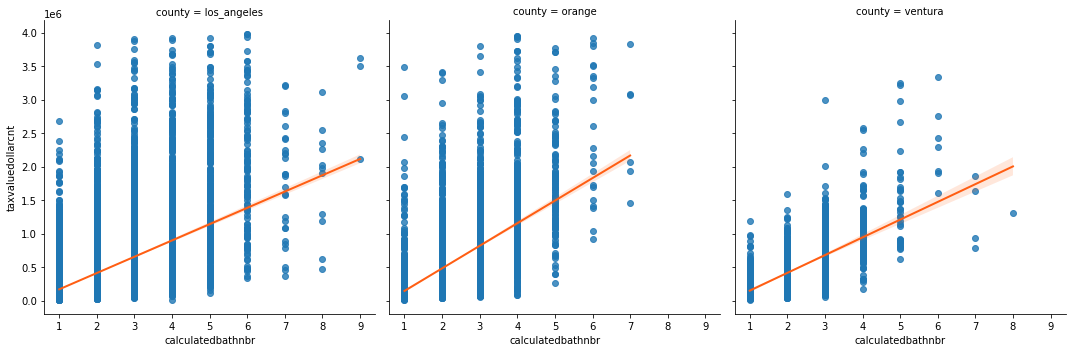

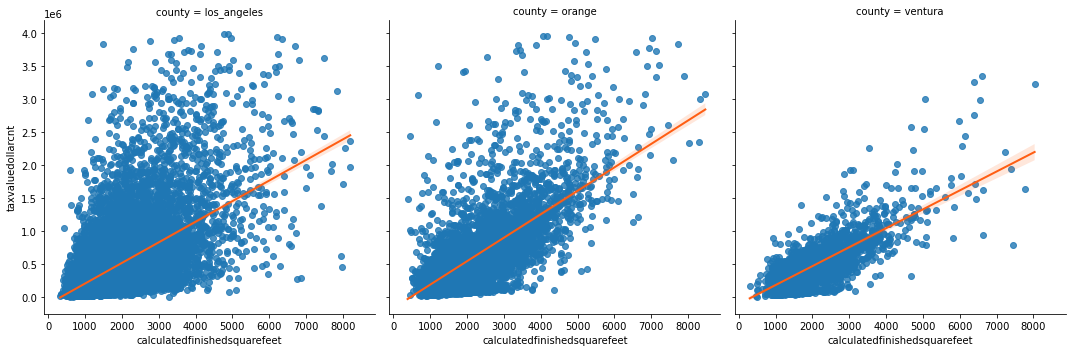

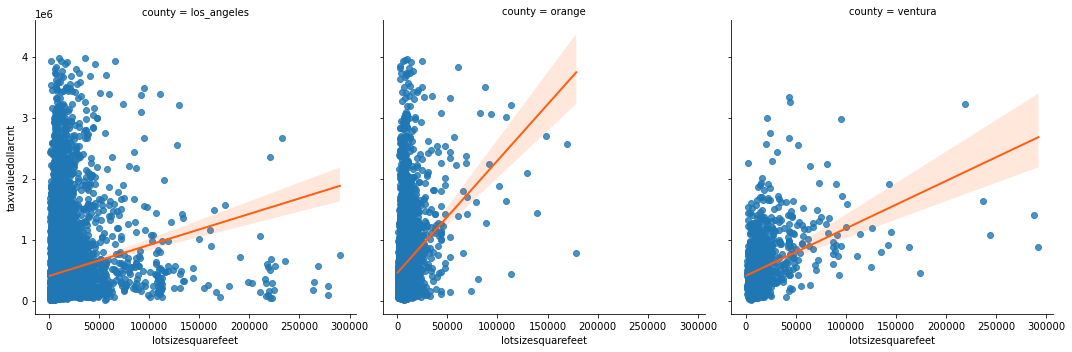

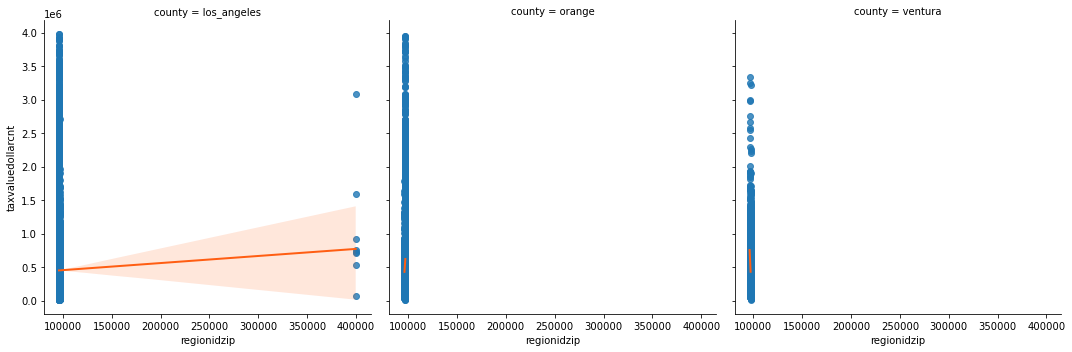

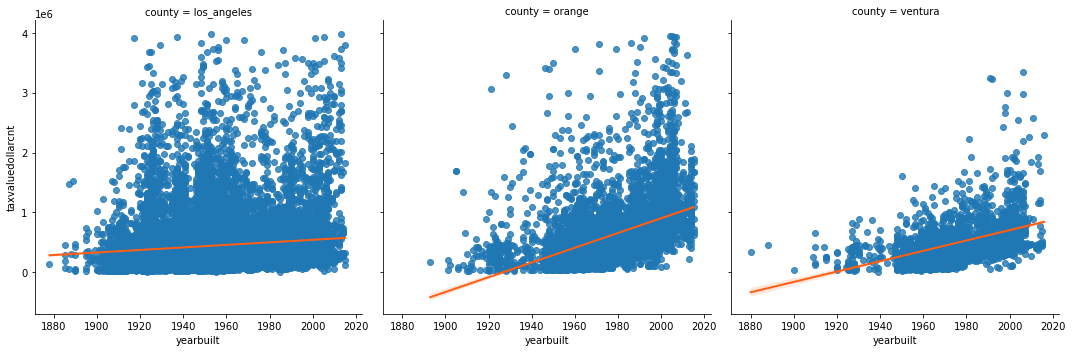

In [55]:
# Making visualizations of all data separated out by county to see if thee is any differences
for column in columns_to_viz:
    sns.lmplot(x=column, y='taxvaluedollarcnt', data=train, height=5, col='county', line_kws={'color': '#FF5E13', 'linewidth': 2},)

### Takeaways from visualizations separated by county categorical

There are some major differences when seperating out by county, specifically on calculatefinishedsquarefeet and yearbuilt. In fact yearbuilt looked like junk when plotted against the whole data but when pulled out it looks like a good predictor for Orange and Ventura county but not for Los Angeles county.

I will make my model by using all the data aggregated initially, but then look to see how much better I can do when separating by county.

First though I need to look at correlations.

**Exploring correlations**

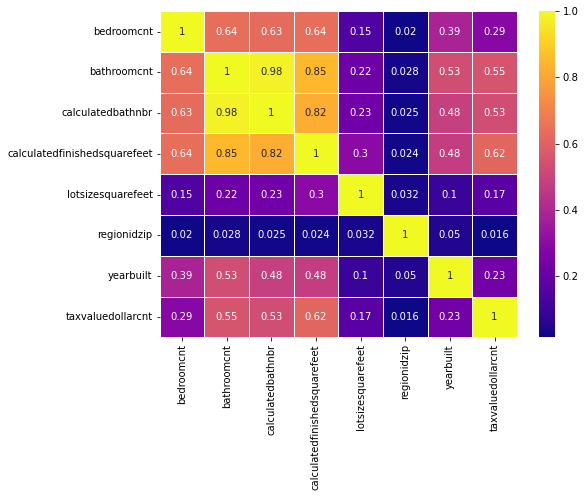

In [56]:
train_corr = train.drop(columns=['county']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='plasma', annot=True, linewidth=0.5)

plt.show()

### Takeaways from heatmap of correlations
Looking at this heatmap, I'm not super encouraged by the correlations I have here. Nothing stands out as being particularly strongly correlated to the target.
- Bathroomcnt and calculatedbathnbr are essentially the same thing as they are correrlated at .98.
    - Because of this I should pick the feature that has the best correlation with the target and drop the other.
    - Since bathroomcnt is .55 and calculatedbathnbr is .53, I will keep bathroomcnt and drop the other when modeling.
- Bedroomcnt is .29 so while not strong I will include it initially in my model
- The strongest relationship to the target variable is calculatedfinishedsquarefeet at .62
- Suprisingly, lotsizesquarefeet is the weakest correlation of all the continuous variables; I will not be using this in my model.
- Yearbuilt has a weak enough correlation that I will leave it out of my model initially.
- I will not be including regionidzip as this is a categorical variable represented numerically.

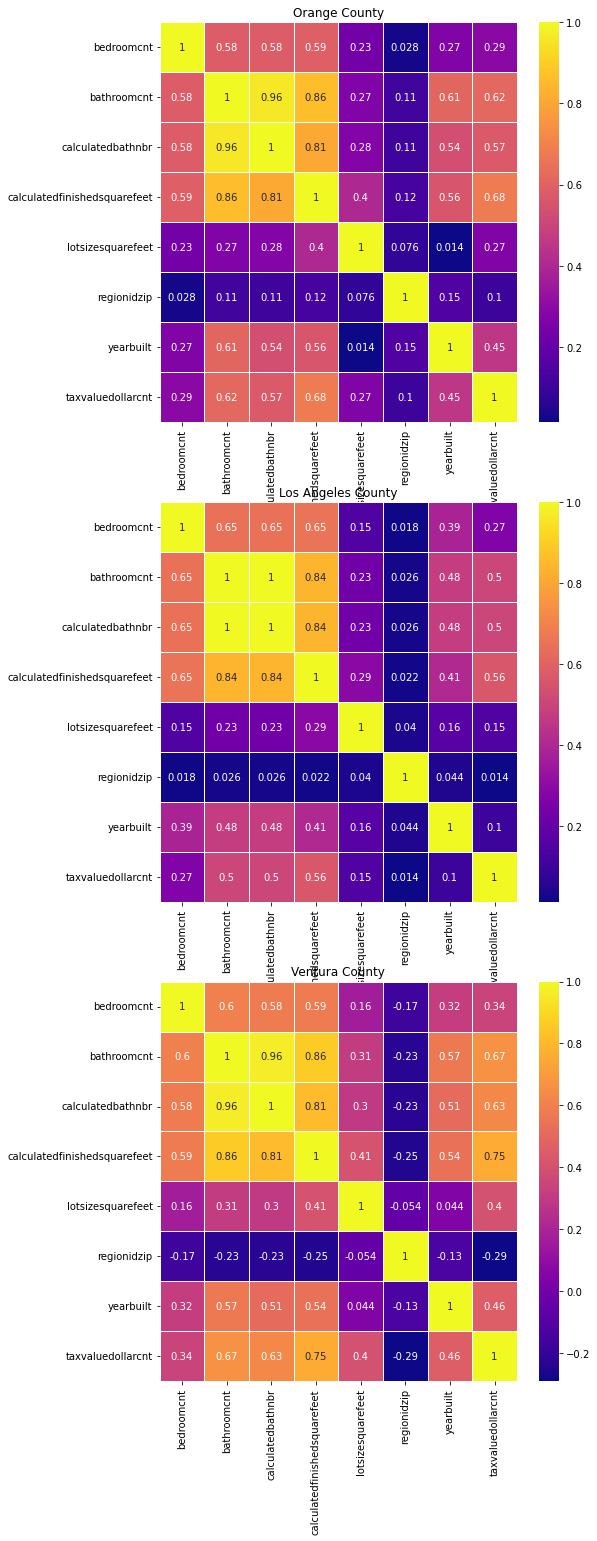

In [57]:
plt.figure(figsize=(8,25))

plt.subplot(311)
orange_corr = train[train.county == 'orange']
orange_corr = orange_corr.drop(columns=['county']).corr()
ax = sns.heatmap(orange_corr, cmap='plasma', annot=True, linewidth=0.5, )

ax.set_title('Orange County')

plt.subplot(312)
la_corr = train[train.county == 'los_angeles']
la_corr = la_corr.drop(columns=['county']).corr()
bx = sns.heatmap(la_corr, cmap='plasma', annot=True, linewidth=0.5)
bx.set_title('Los Angeles County')

plt.subplot(313)
ventura_corr = train[train.county == 'ventura']
ventura_corr = ventura_corr.drop(columns=['county']).corr()
cx = sns.heatmap(ventura_corr, cmap='plasma', annot=True, linewidth=0.5)
cx.set_title('Ventura County')

plt.show()

### Takeaways from heatmap of correlations split by counties
These separated heatmaps seem to indicate that there is a difference between counties in certain featues when correlated to the target.
- Bathroomcnt and calculatedbathnbr are still essentially the same thing.
- All other variables have a stronger correlation in Orange and Ventura County, whereas everything else is weaker in Los Angeles county.
    - Maybe make separate models based on county.
    
- I need to do some hypothesis testing to see if my findings about these correlations are actually statistically significant.

#### Hypothesis testing

##### Hypothesis 1:

$H_{0}$ Homes in Orange County and Ventura County have a lower or equal taxvaluedollarcnt than Los Angeles County.

$H_{a}$ Homes in Orange County and Ventura County have a higher taxvaluedollarcnt than Los Angeles County.


In [58]:
# Setting variables
alpha = .05

orange_ventura = train[(train.county == 'orange') | (train.county == 'ventura')]
la_county = train[train.county == 'los_angeles']

In [59]:
# Checking for variance with levene

stats.levene(orange_ventura.taxvaluedollarcnt, la_county.taxvaluedollarcnt)
# No equal variance for these two groups

LeveneResult(statistic=17.9569945706127, pvalue=2.2665436929199795e-05)

In [60]:
t, p = stats.ttest_ind(orange_ventura.taxvaluedollarcnt, la_county.taxvaluedollarcnt, equal_var=False)

(p/2) < alpha

True

In [61]:
t

19.767291526267048

Because p/2 is less than alpha and the t value is positive, I can reject the null hypothesis. Homes in Orange county and Ventura county have a higher taxvaluedollarcnt than homes in Los Angeles county.

##### Hypothesis 2

$H_{0}$ There is no linear correlation between calculatedfinishedsquarefeet and taxvaluedollarcnt.

$H_{a}$ There is a linear correlation between calculatedfinishedsquarefeet and taxvaluedollarcnt.

In [62]:
corr, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
p < alpha, corr

(True, 0.6155847381399193)

I reject the null hypothesis. There is a statistically significant linear correlation between calculatedfinishedsquarefeet and taxvaluedollarcnt; this relationship is moderately strong with an r value of .5572, so what I saw represented above is confirmed to be statistically valid to use in our model. This is good as it's the strongest general feature observed.

##### Hypothesis 3

$H_{0}$ There is no linear correlation between yearbuilt and taxvaluedollarcnt.

$H_{a}$ There is a linear correlation between yearbuilt and taxvaluedollarcnt.

In [63]:
corr, p = stats.pearsonr(train.yearbuilt, train.taxvaluedollarcnt)
p < alpha

True

In [64]:
corr, p

(0.23338338817710566, 0.0)

I reject the null hypothesis. There is a statistically significant linear correlation between yearbuilt and taxvaluedollarcnt; this relationship while existant is not very strong with an r value of .2746. 

Despite statistical significance, it's not a very strong correlation. I want to do a t-test below to see if there is a statistically relevant difference between yearbuilt for homes in Orange and Ventura county as compared to LA county.

##### Hypothesis 4

$H_{0}$ Yearbuilt for homes in Orange and Ventura county equals that of homes in Los Angeles county.

$H_{a}$ Yearbuilt for homes in Orange and Ventura county does NOT equal that of homes in Los Angeles county.

In [65]:
# Checking for variance with levene

stats.levene(orange_ventura.yearbuilt, la_county.yearbuilt)
# No equal variance for these two groups

LeveneResult(statistic=120.4994649577136, pvalue=5.587728781090432e-28)

In [66]:
t, p = stats.ttest_ind(orange_ventura.yearbuilt, la_county.yearbuilt, equal_var=False)

p < alpha

True

In [67]:
t

73.54618620744645

Because p is less than alpha I can reject the null hypothesis. Yearbuilt for homes in Orange county and Ventura county do not equal that of homes in Los Angeles county. Further, since the t value is positive I can conclude that yearbuilt is higher for homes in Orange and Ventura county meaning that these homes are newer.

##### Hypothesis 5

$H_{0}$ There is no linear correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura county.

$H_{a}$ There is a linear correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura county.

In [68]:
corr, p = stats.pearsonr(orange_ventura.yearbuilt, orange_ventura.taxvaluedollarcnt)
p < alpha

True

In [69]:
corr, p

(0.44323311910245433, 0.0)

I reject the null hypothesis. There is a statistically significant linear correlation between yearbuilt and taxvaluedollarcnt for homes in Orange and Ventura county; this relationship is noticeably stronger at .44 that the overall relationship of .2746 which included Los Angeles county. 

### Hypothesis testing Takeaways

1. Homes in LA have an lower average taxvaluedollarcnt than homes in Ventura and Orange county.
2. The strongest linear correlation was calculatedfinishedsquarefeet and has been determined to be statistically significant so I will be using it for my model.
3. While yearbuilt does not have a strong correlation for the entire dataset, it becomes more robust when Los Angeles county is taken out of the calculations. This supports my idea that separating out counties could result in better individual models as there is data which is correlated more/less depending on county.
    - This is further seen from the t-test showing that on average homes in Los Angeles country are older than homes in Orange county and Ventura county

### Exploration Takeaways
- calculatedfinishedsquarefeet has the tightest correlation to the target variable.
- There are statistically significant between counties in which features are most tightly correlated to the target variable.
    - When separated by county Los Angeles county seems to have the weakest correlations between features and target.
- It will be valuable to build an overall predictive model but the construct individual models for each county. 
    - This means I will need to check my data for stratification and if it's not equal, then I will have to stratify my train, validate, test splits by county to make sure I get equal distribution of the data.


In [70]:
train[train.county == 'los_angeles'].shape[0]/train.shape[0], train[train.county == 'orange'].shape[0]/train.shape[0], train[train.county == 'ventura'].shape[0]/train.shape[0]

(0.6429488291413703, 0.27181266261925413, 0.08523850823937554)

In [71]:
validate[validate.county == 'los_angeles'].shape[0]/validate.shape[0], validate[validate.county == 'orange'].shape[0]/validate.shape[0], validate[validate.county == 'ventura'].shape[0]/validate.shape[0]

(0.6421401975068803, 0.27391937833899954, 0.08394042415412012)

In [72]:
test[test.county == 'los_angeles'].shape[0]/test.shape[0], test[test.county == 'orange'].shape[0]/test.shape[0], test[test.county == 'ventura'].shape[0]/test.shape[0]

(0.6551724137931034, 0.2640116561437591, 0.08081593006313745)

As seen above, while not perfect, there is an approximate level of stratification already built into the data at roughly 66% made up of los_angeles, .27% made up of orange, and 8% made up of ventura across train, validate, and test subsets.

# Modeling

In [73]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

Going forward, I will be using my scaled datasets for modeling.

In [74]:
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidzip,yearbuilt,county,taxvaluedollarcnt
23156,0.125,0.1250,0.125,0.151623,0.027058,0.001455,0.434783,los_angeles,102269.0
2568,0.375,0.1250,0.125,0.107287,0.019260,0.001587,0.550725,los_angeles,324566.0
21142,0.375,0.3125,0.250,0.243478,0.008368,0.003467,0.913043,orange,709000.0
697,0.250,0.1250,0.125,0.159584,0.018447,0.000425,0.500000,los_angeles,351733.0
24151,0.250,0.1875,0.125,0.264911,0.023409,0.003629,0.913043,ventura,610000.0


Getting baselines based on mean and median

In [75]:
X_train_scaled = train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train_scaled = pd.DataFrame(train_scaled.taxvaluedollarcnt)


X_validate_scaled = validate_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_validate_scaled = pd.DataFrame(validate_scaled.taxvaluedollarcnt)

X_test_scaled = test_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_test_scaled = pd.DataFrame(test_scaled.taxvaluedollarcnt)

In [76]:
# Predicting the mean for taxvaluedollarcnt

taxvalue_mean = y_train_scaled.taxvaluedollarcnt.mean()
y_train_scaled['taxvalue_pred_mean'] = taxvalue_mean
y_validate_scaled['taxvalue_pred_mean'] = taxvalue_mean
y_test_scaled['taxvalue_pred_mean'] = taxvalue_mean

In [77]:
# Predicting the median for taxvaluedollarcnt

taxvalue_median = y_train_scaled.taxvaluedollarcnt.median()
y_train_scaled['taxvalue_pred_median'] = taxvalue_median
y_validate_scaled['taxvalue_pred_median'] = taxvalue_median
y_test_scaled['taxvalue_pred_median'] = taxvalue_median

In [78]:
# Getting the RMSE taxvalue_pred_mean

rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# Getting the RMSE taxvalue_pred_median
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_median)**(1/2)

print("\nRMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  477010.2 
Validate/Out-of-Sample:  479022.19

RMSE using Median
Train/In-Sample:  491569.8 
Validate/Out-of-Sample:  492880.69


## LinearRegression (OLS)
Creating and validating a linear regression model.

In [79]:
# create the model
lm = LinearRegression()

#fit the model
lm.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lm)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  367980.6553866153 
Validation/Out-of-Sample:  369039.877178717


This model does better by about 100,000 when compared to the baseline mean prediction.

## LassoLars
Creating and validating a LassoLars model.

In [80]:
# create the model
lars = LassoLars(alpha=1.0)

# fit the model
lars.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367980.8981000375 
Validation/Out-of-Sample:  369041.8821638619


This model does better by about 100,000 when compared to the baseline mean prediction. In fact, it's suprisingly close to the results for the OLS model.

## TweedieRegressor (GLM)
Creating and validating a tweedie regressor model.

In [81]:
# create the model 
glm = TweedieRegressor(power=1, alpha=0)

# fit the model
glm.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_glm)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_glm)**(1/2)

print("RMSE for GLM  using Tweedie\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM  using Tweedie
Training/In-Sample:  389552.4035165603 
Validation/Out-of-Sample:  388018.041575633


This performs better than baseline but not as good as the previous two models.

## Polynomial Regression
Creating and validatiing a polynomial regressor.

In [82]:
# making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [83]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  364349.56740119046 
Validation/Out-of-Sample:  365217.64653510664


This model performs the best so far beating the previous ones by a few thousand.

In [84]:
y_train_scaled.head()

,taxvaluedollarcnt,taxvalue_pred_mean,taxvalue_pred_median,taxvalue_pred_lm,taxvalue_pred_lars,taxvalue_pred_glm,taxvalue_pred_lm2
23156,102269.0,491457.441284,372705.0,492704.811725,492157.513743,433896.366461,463261.007287
2568,324566.0,491457.441284,372705.0,167225.715383,167909.193513,302299.069683,210449.673771
21142,709000.0,491457.441284,372705.0,645171.728592,645106.838393,576982.624221,621917.433362
697,351733.0,491457.441284,372705.0,407404.439846,407399.497709,394153.908627,390131.867135
24151,610000.0,491457.441284,372705.0,720758.681101,720359.010108,578564.223639,674188.247628


### Hyperparameter Tuning and other models

In [85]:
# create the model
lars_v2 = LassoLars(alpha=2)

# fit the model
lars_v2.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars_v2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars_v2)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367981.6262393434 
Validation/Out-of-Sample:  369044.3765044528


In [86]:
# create the model
lars_v2 = LassoLars(alpha=5, max_iter  = 1000)

# fit the model
lars_v2.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars_v2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars_v2)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367986.72317414253 
Validation/Out-of-Sample:  369054.7955499461


No appreciable differences in the standard hyperparameters, in fact works slightly worse than default. 

In [87]:
# Importing other versions of lasso/lars to try
from sklearn.linear_model import Lars, Lasso, LassoLarsCV, LassoLarsIC


In [88]:
# create the model
lars_v2 = Lars()

# fit the model
lars_v2.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars_v2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars_v2)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367980.6553866153 
Validation/Out-of-Sample:  369039.877178717


In [89]:
# create the model
lars_v2 = Lasso()

# fit the model
lars_v2.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars_v2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars_v2)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367980.65603029745 
Validation/Out-of-Sample:  369040.0056028687


In [90]:
# create the model
lars_v2 = LassoLarsCV()

# fit the model
lars_v2.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars_v2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars_v2)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367980.6553866153 
Validation/Out-of-Sample:  369039.877178717


In [91]:
# create the model
lars_v2 = LassoLarsIC()

# fit the model
lars_v2.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

# predict train
y_train_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars_v2)**(1/2)

# predict validate
y_validate_scaled['taxvalue_pred_lars_v2'] = lars_v2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars_v2)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367980.6553866153 
Validation/Out-of-Sample:  369039.877178717


No real appreciable differences in the variations of the Lasso/Lars models.

In [92]:
from sklearn.linear_model import Ridge, SGDRegressor, ARDRegression, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor

In [93]:
for model in [Ridge, SGDRegressor, ARDRegression, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor]:
    # create the model
    test_model = model()

    # fit the model
    test_model.fit(X_train_scaled, y_train_scaled.taxvaluedollarcnt)

    # predict train
    y_train_scaled['taxvalue_pred_test'] = test_model.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_test)**(1/2)

    # predict validate
    y_validate_scaled['taxvalue_pred_test'] = test_model.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_test)**(1/2)

    print(f"\nRMSE for {model}\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for <class 'sklearn.linear_model._ridge.Ridge'>
Training/In-Sample:  367983.4644769999 
Validation/Out-of-Sample:  369072.59907623834

RMSE for <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
Training/In-Sample:  368150.13699866744 
Validation/Out-of-Sample:  369455.8126179372

RMSE for <class 'sklearn.linear_model._bayes.ARDRegression'>
Training/In-Sample:  367980.67799597135 
Validation/Out-of-Sample:  369038.5611409761

RMSE for <class 'sklearn.linear_model._bayes.BayesianRidge'>
Training/In-Sample:  367980.6632210182 
Validation/Out-of-Sample:  369041.4706304085

RMSE for <class 'sklearn.linear_model._huber.HuberRegressor'>
Training/In-Sample:  380055.25039209024 
Validation/Out-of-Sample:  381676.21893710684

RMSE for <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>
Training/In-Sample:  405273.14876766456 
Validation/Out-of-Sample:  407602.6616813272


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [108]:
# initial_model_results = pd.read_clipboard()

# initial_model_results

,model,train_RMSE,validate_RMSE
0,train_mean,477010.2000,479022.1900
1,train_median,491569.8000,492880.6900
2,linear_regression_ols,367980.6554,369039.8772
3,lasso_lars,367980.8981,369041.8822
4,tweedie_regressor_glm,389552.3893,388018.0318
5,polynomial_regression,364349.5674,365217.6465
6,ridge_regressor,367983.4645,369072.5991
7,sgd_regressor,368323.8206,369760.0555
8,ard_regressor,367980.6780,369038.5611
9,bayesian_ridge,367980.6632,369041.4706


In [120]:
model_results.model.values

array(['train_mean', 'train_median', 'linear_regression_ols',
       'lasso_lars', 'tweedie_regressor_glm', 'polynomial_regression',
       'ridge_regressor', 'sgd_regressor', 'ard_regressor',
       'bayesian_ridge', 'huber_regressor',
       'passive_aggressive_regressor'], dtype=object)

In [109]:
# initial_model_results.to_csv('model_results.csv', index=False)
model_results = pd.read_csv('model_results.csv')

In [110]:
model_results

,model,train_RMSE,validate_RMSE
0,train_mean,477010.2000,479022.1900
1,train_median,491569.8000,492880.6900
2,linear_regression_ols,367980.6554,369039.8772
3,lasso_lars,367980.8981,369041.8822
4,tweedie_regressor_glm,389552.3893,388018.0318
5,polynomial_regression,364349.5674,365217.6465
6,ridge_regressor,367983.4645,369072.5991
7,sgd_regressor,368323.8206,369760.0555
8,ard_regressor,367980.6780,369038.5611
9,bayesian_ridge,367980.6632,369041.4706


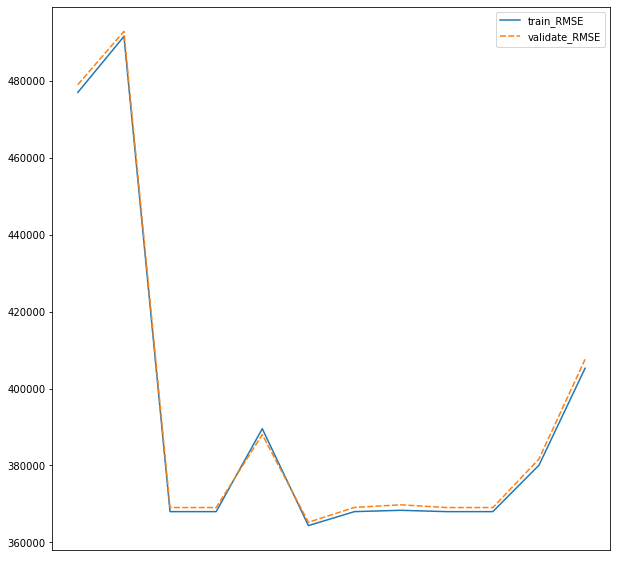

In [118]:
plt.figure(figsize=(10,10))
mod = sns.lineplot(data=model_results)
mod.set(xticklabels=[])
mod.set(xticks=[])
plt.show()

#### Other models and hyperparamter tuning Takeaways
None of these models with default hyperparameters do any better than my previous models.

I will be going with my original LassoLars model with standard hyperparameters from above. It had the results seen below

In [98]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.taxvaluedollarcnt, y_train_scaled.taxvalue_pred_lars)**(1/2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.taxvaluedollarcnt, y_validate_scaled.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  367980.8981000375 
Validation/Out-of-Sample:  369041.8821638619


#### Further modeling

This is my new baseline. I want to go back to my train_scaled, validate_scaled, and test_scaled subsets and separate them out by county in order to see if I can create 3 new models which perform individually better than the baseline.

In [99]:
train_la = train_scaled[train_scaled.county == 'los_angeles']
train_orange = train_scaled[train_scaled.county == 'orange']
train_ventura = train_scaled[train_scaled.county == 'ventura']

validate_la = validate_scaled[validate_scaled.county == 'los_angeles']
validate_orange = validate_scaled[validate_scaled.county == 'orange']
validate_ventura = validate_scaled[validate_scaled.county == 'ventura']

test_la = test_scaled[test_scaled.county == 'los_angeles']
test_orange = test_scaled[test_scaled.county == 'orange']
test_ventura = test_scaled[test_scaled.county == 'ventura']

For this, I'm going to add in some features that were better predictors for orange and ventura counties, but see how they impact Los Angeles county's predictions.

In [100]:
X_train_la = train_la[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_train_la = pd.DataFrame(train_la.taxvaluedollarcnt)

X_train_orange = train_orange[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_train_orange = pd.DataFrame(train_orange.taxvaluedollarcnt)

X_train_ventura = train_ventura[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_train_ventura = pd.DataFrame(train_ventura.taxvaluedollarcnt)



X_validate_la = validate_la[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_validate_la = pd.DataFrame(validate_la.taxvaluedollarcnt)

X_validate_orange = validate_orange[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_validate_orange = pd.DataFrame(validate_orange.taxvaluedollarcnt)

X_validate_ventura = validate_ventura[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_validate_ventura = pd.DataFrame(validate_ventura.taxvaluedollarcnt)



X_test_la = test_la[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_test_la = pd.DataFrame(test_la.taxvaluedollarcnt)

X_test_orange = test_orange[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_test_orange = pd.DataFrame(test_orange.taxvaluedollarcnt)

X_test_ventura = test_ventura[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']]
y_test_ventura = pd.DataFrame(test_ventura.taxvaluedollarcnt)

#### LassoLars model for Los Angeles county

In [101]:
# create the model
lars_v2 = LassoLars(alpha=1.0)

# fit the model
lars_v2.fit(X_train_la, y_train_la.taxvaluedollarcnt)

# predict train
y_train_la['taxvalue_pred_lars'] = lars_v2.predict(X_train_la)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_la.taxvaluedollarcnt, y_train_la.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate_la['taxvalue_pred_lars'] = lars_v2.predict(X_validate_la)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_la.taxvaluedollarcnt, y_validate_la.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  378475.2871964812 
Validation/Out-of-Sample:  379391.8324818286


This model is slightly worse than the original baseline.

In [102]:
#Comparing this to the original model features while split to LA county alone.

X_train_la_original_features = train_la[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_train_la_original_features = pd.DataFrame(train_la.taxvaluedollarcnt)

X_validate_la_original_features = validate_la[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_validate_la_original_features = pd.DataFrame(validate_la.taxvaluedollarcnt)

X_test_la_original_features = test_la[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
y_test_la_original_features = pd.DataFrame(test_la.taxvaluedollarcnt)

# create the model
lars_v2 = LassoLars(alpha=1.0)

# fit the model
lars_v2.fit(X_train_la_original_features, y_train_la_original_features.taxvaluedollarcnt)

# predict train
y_train_la_original_features['taxvalue_pred_lars'] = lars_v2.predict(X_train_la_original_features)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_la_original_features.taxvaluedollarcnt, y_train_la_original_features.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate_la_original_features['taxvalue_pred_lars'] = lars_v2.predict(X_validate_la_original_features)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_la_original_features.taxvaluedollarcnt, y_validate_la_original_features.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  384691.0737745738 
Validation/Out-of-Sample:  385157.7985485139


This model doesn't perform as well as the one above did with the additional features added in.

#### LassoLars model for Orange county

In [103]:
# create the model
lars_v2 = LassoLars(alpha=1.0)

# fit the model
lars_v2.fit(X_train_orange, y_train_orange.taxvaluedollarcnt)

# predict train
y_train_orange['taxvalue_pred_lars'] = lars_v2.predict(X_train_orange)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_orange.taxvaluedollarcnt, y_train_orange.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate_orange['taxvalue_pred_lars'] = lars_v2.predict(X_validate_orange)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_orange.taxvaluedollarcnt, y_validate_orange.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  358327.75642195053 
Validation/Out-of-Sample:  357547.43673827854


This is somewhat better than baseline.

#### LassoLars model for Ventura county

In [104]:
# create the model
lars_v2 = LassoLars(alpha=1.0)

# fit the model
lars_v2.fit(X_train_ventura, y_train_ventura.taxvaluedollarcnt)

# predict train
y_train_ventura['taxvalue_pred_lars'] = lars_v2.predict(X_train_ventura)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_ventura.taxvaluedollarcnt, y_train_ventura.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate_ventura['taxvalue_pred_lars'] = lars_v2.predict(X_validate_ventura)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_ventura.taxvaluedollarcnt, y_validate_ventura.taxvalue_pred_lars)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for LassoLars
Training/In-Sample:  221824.2509632955 
Validation/Out-of-Sample:  260174.64882082216


This is significantly better than the original baseline lassolars model.

Separated models Takeaways:
- The Los Angeles county model performed slightly worse than the orignal model.
- The Orange county model performed slightly better than the original model.
- The Ventura county model performed significantly better than the original model.

**Trying with a polynomial regression just to see.**

In [122]:
# making the polynomial features to get a new set of features
pf_la = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2_la = pf_la.fit_transform(X_train_la)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_la = pf_la.transform(X_validate_la)
X_test_degree2_la = pf_la.transform(X_test_la)

# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2_la, y_train_la.taxvaluedollarcnt)

# predict train
y_train_la['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2_la)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_la.taxvaluedollarcnt, y_train_la.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate_la['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2_la)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_la.taxvaluedollarcnt, y_validate_la.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model for LA county, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model for LA county, degrees=2
Training/In-Sample:  375023.72334097576 
Validation/Out-of-Sample:  376159.6203252768


This model performs better than the previous LassoLars model for LA county by a few thousand.

In [123]:
# making the polynomial features to get a new set of features
pf_orange = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2_orange = pf_orange.fit_transform(X_train_orange)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_orange = pf_orange.transform(X_validate_orange)
X_test_degree2_orange = pf_orange.transform(X_test_orange)

# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2_orange, y_train_orange.taxvaluedollarcnt)

# predict train
y_train_orange['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2_orange)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_orange.taxvaluedollarcnt, y_train_orange.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate_orange['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2_orange)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_orange.taxvaluedollarcnt, y_validate_orange.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model for Orange county, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model for Orange county, degrees=2
Training/In-Sample:  343852.54942392476 
Validation/Out-of-Sample:  346354.63713526935


This model also performs noticably better than the previous LassoLars model for Orange county.

In [124]:
# making the polynomial features to get a new set of features
pf_ventura = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2_ventura = pf_ventura.fit_transform(X_train_ventura)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2_ventura = pf_ventura.transform(X_validate_ventura)
X_test_degree2_ventura = pf_ventura.transform(X_test_ventura)

# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2_ventura, y_train_ventura.taxvaluedollarcnt)

# predict train
y_train_ventura['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2_ventura)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_ventura.taxvaluedollarcnt, y_train_ventura.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate_ventura['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2_ventura)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_ventura.taxvaluedollarcnt, y_validate_ventura.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model for Ventura county, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model for Ventura county, degrees=2
Training/In-Sample:  213924.58367415334 
Validation/Out-of-Sample:  254042.85275017304


Finally, it performed better for Ventura county as well.

## Modeling final Takeaways

The best performing model I arrived at was actually a split of 3 models each one specific for each county; all models were polynomial regression models with a degree of 2. See how the actual prices compare to the predicted prices below.

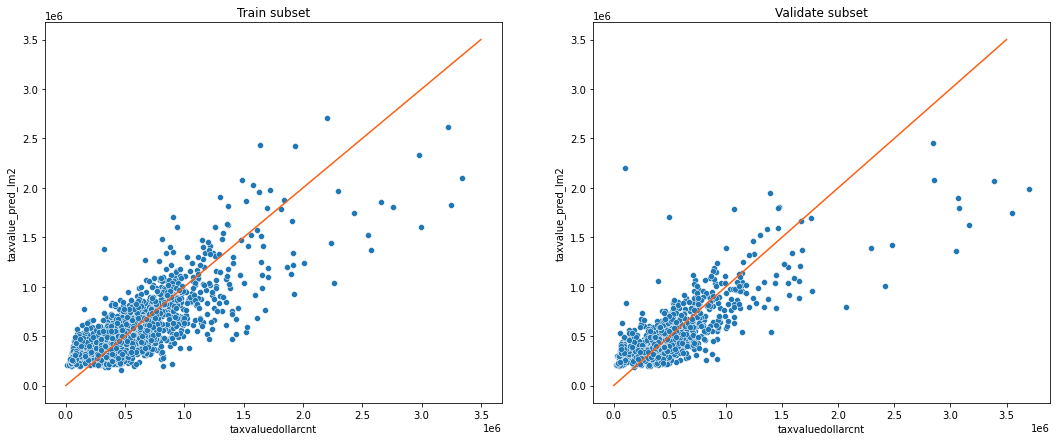

In [125]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
sns.scatterplot(data = y_train_ventura, x = 'taxvaluedollarcnt', y = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,3500000), y=(0,3500000), color = '#FF5E13')
plt.title('Train subset')


plt.subplot(122)
sns.scatterplot(data = y_validate_ventura, x = 'taxvaluedollarcnt', y = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,3500000), y=(0,3500000), color = '#FF5E13')
plt.title('Validate subset')
plt.show()

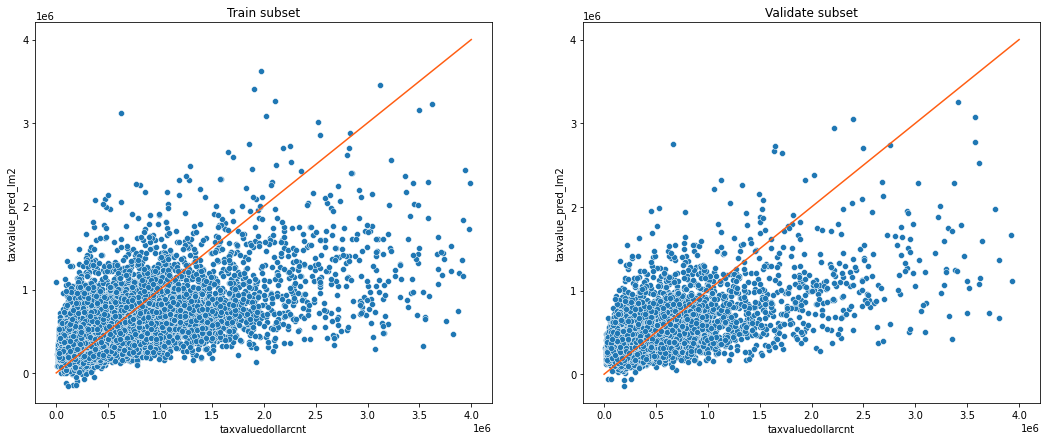

In [126]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
sns.scatterplot(data = y_train_la, x = 'taxvaluedollarcnt', y = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,4000000), y=(0,4000000), color = '#FF5E13')
plt.title('Train subset')

plt.subplot(122)
sns.scatterplot(data = y_validate_la, x = 'taxvaluedollarcnt', y = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,4000000), y=(0,4000000), color = '#FF5E13')
plt.title('Validate subset')

plt.show()

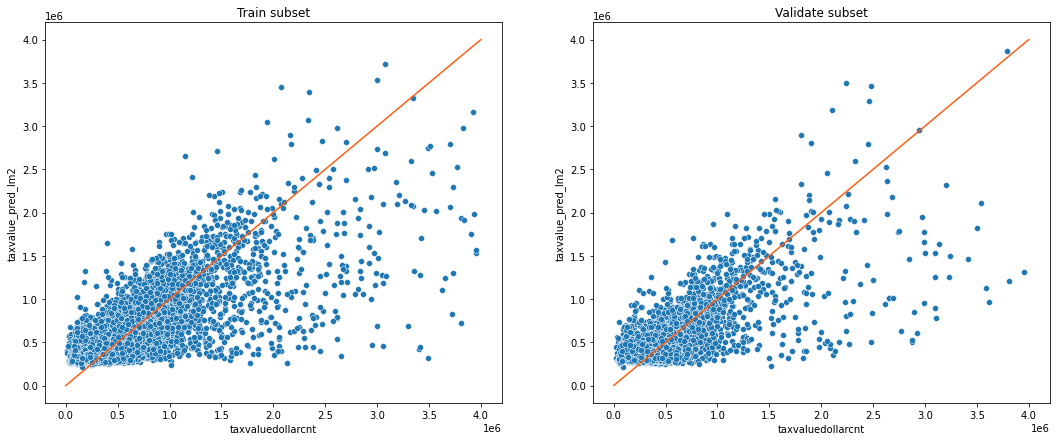

In [127]:
plt.figure(figsize=(18, 7))
plt.subplot(121)
sns.scatterplot(data = y_train_orange, x = 'taxvaluedollarcnt', y = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,4000000), y=(0,4000000), color = '#FF5E13')
plt.title('Train subset')

plt.subplot(122)
sns.scatterplot(data = y_validate_orange, x = 'taxvaluedollarcnt', y = 'taxvalue_pred_lm2')
sns.lineplot(x=(0,4000000), y=(0,4000000), color = '#FF5E13')
plt.title('Validate subset')

plt.show()

Text(0.5, 1.0, 'Validate subset')

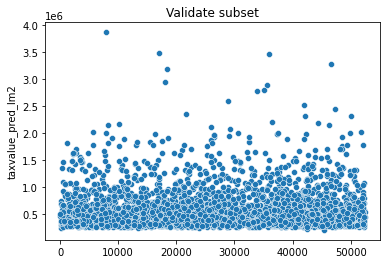

In [134]:
sns.scatterplot(data = y_validate_orange, x = y_validate_orange.index, y = 'taxvalue_pred_lm2')
# sns.lineplot(x=(0,4000000), y=(0,4000000), color = '#FF5E13')
plt.title('Validate subset')

In [131]:
y_validate_orange.index

Int64Index([47030, 17597, 39463, 16126,  8491, 25409,  5085, 17191,  6935,
            12881,
            ...
            25376, 18746, 48038,  6965, 13485, 24420,  1223, 40296, 21794,
            26457],
           dtype='int64', length=3384)

<AxesSubplot:>

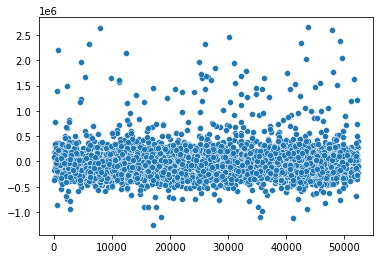

In [141]:
sns.scatterplot(data = y_validate_orange, x = y_validate_orange.index, y = y_validate_orange.taxvaluedollarcnt - y_validate_orange.taxvalue_pred_lm2)





<AxesSubplot:ylabel='taxvaluedollarcnt'>

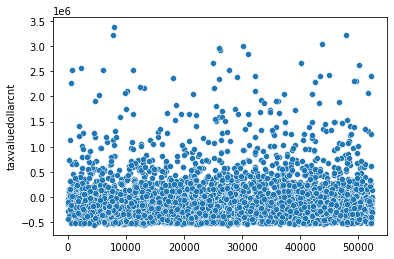

In [140]:
sns.scatterplot(data = y_validate_orange, x = y_validate_orange.index, y = y_validate_orange.taxvaluedollarcnt- y_validate_orange.taxvaluedollarcnt.mean())



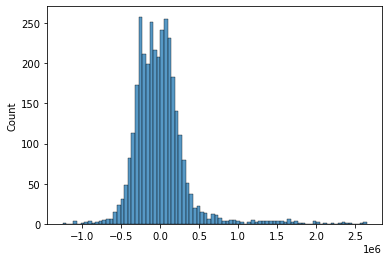

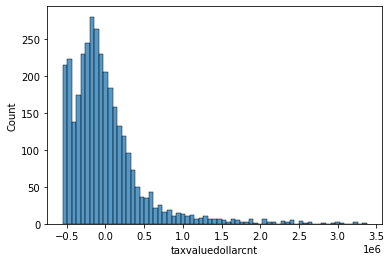

In [151]:
sns.histplot(data = y_validate_orange, x= y_validate_orange.taxvaluedollarcnt - y_validate_orange.taxvalue_pred_lm2)
plt.show()
sns.histplot(data = y_validate_orange, x = y_validate_orange.taxvaluedollarcnt- y_validate_orange.taxvaluedollarcnt.mean())
plt.show()




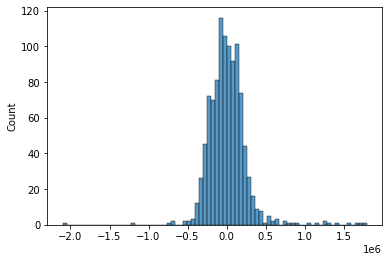

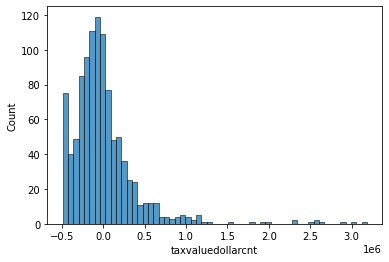

In [152]:
sns.histplot(data = y_validate_ventura, x= y_validate_ventura.taxvaluedollarcnt - y_validate_ventura.taxvalue_pred_lm2)
plt.show()
sns.histplot(data = y_validate_ventura, x = y_validate_ventura.taxvaluedollarcnt- y_validate_ventura.taxvaluedollarcnt.mean())
plt.show()




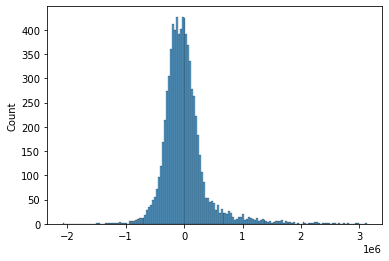

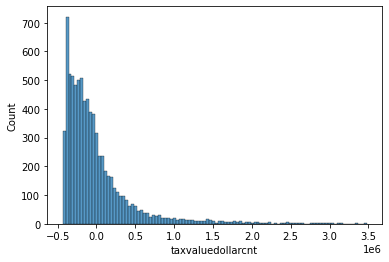

In [153]:
sns.histplot(data = y_validate_la, x= y_validate_la.taxvaluedollarcnt - y_validate_la.taxvalue_pred_lm2)
plt.show()
sns.histplot(data = y_validate_la, x = y_validate_la.taxvaluedollarcnt- y_validate_la.taxvaluedollarcnt.mean())
plt.show()


